In [13]:
import pickle
import numpy as np
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
# declare fews variables

data_path = "data/"
image_shape = (224, 224, 3)
epochs = 50
callback = lambda x: [EarlyStopping(monitor='val_loss', patience=2, mode="min"), ModelCheckpoint(filepath=f"{data_path}{x}_model.h5", monitor='val_loss', save_best_only=True)]

In [3]:
# helper function

def show_result(steps: dict):
    """
    Used to display model's results after his training
    :param steps: contains all the history of the training model
    """
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_title("Learning curves")
    ax.set(xlabel='Epochs', ylabel='Metrics')
    sns.lineplot(x=range(len(steps["loss"])), y=steps["loss"], label="train loss", ax=ax)
    sns.lineplot(x=range(len(steps["loss"])), y=steps["val_loss"], label="val loss", ax=ax)
    sns.lineplot(x=range(len(steps["loss"])), y=steps["accuracy"], label="train accuracy", ax=ax)
    sns.lineplot(x=range(len(steps["loss"])), y=steps["val_accuracy"], label="val accuracy", ax=ax)

## I - Load data

In [4]:
with open(f'{data_path}train_test_split.pickle', 'rb') as handle:
    data = pickle.load(handle)

X_train, y_train = data["train"]
X_test, y_test = data["test"]

## II - Custom CNN model

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=image_shape))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/50
88/88 [==============================] - 67s 757ms/step - loss: 0.4090 - accuracy: 0.8278 - val_loss: 0.2302 - val_accuracy: 0.9253
Epoch 2/50
88/88 [==============================] - 67s 756ms/step - loss: 0.2040 - accuracy: 0.9307 - val_loss: 0.1161 - val_accuracy: 0.9677
Epoch 3/50
88/88 [==============================] - 67s 764ms/step - loss: 0.1893 - accuracy: 0.9471 - val_loss: 0.0997 - val_accuracy: 0.9636
Epoch 4/50
88/88 [==============================] - 64s 728ms/step - loss: 0.1535 - accuracy: 0.9411 - val_loss: 0.0869 - val_accuracy: 0.9616
Epoch 5/50
88/88 [==============================] - 66s 750ms/step - loss: 0.1238 - accuracy: 0.9621 - val_loss: 0.0858 - val_accuracy: 0.9636
Epoch 6/50
88/88 [==============================] - 64s 728ms/step - loss: 0.1121 - accuracy: 0.9675 - val_loss: 0.1077 - val_accuracy: 0.9556
Epoch 7/50
88/88 [==============================] - 68s 776ms/step - loss: 0.0975 - accuracy: 0.9700 - val_loss: 0.0885 - val_accuracy: 0.9657

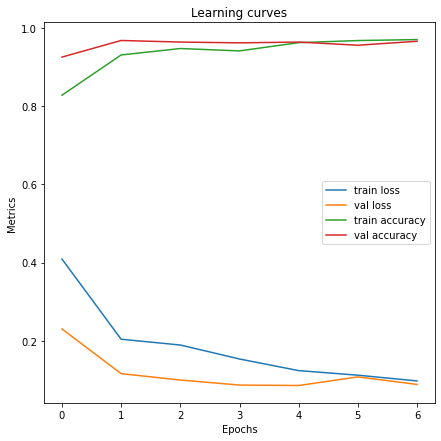

In [6]:
hist = model.fit(X_train, y_train, epochs=50, validation_split=.15, callbacks=callback("CNet"), verbose=1).history
show_result(hist)

In [26]:
y_pred = model.predict(X_test)
y_pred[y_pred <= 0.5], y_pred[y_pred > 0.5] = 0, 1

In [27]:
model = load_model(data_path + "CNet_model.h5")
print("Accuracy test set:",  accuracy_score(y_test, y_pred))

Accuracy test set: 0.9635922330097088


## III - Another approach with transfer learning for feature extraction

In [28]:
# pre trained model here

MNetV2 = MobileNetV2()

MNetV2_features_train = MNetV2.predict(X_train)
MNetV2_features_test = MNetV2.predict(X_test)

In [29]:
model2 = Sequential()
model2.add(Flatten())
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation="sigmoid"))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/50
88/88 [==============================] - 1s 3ms/step - loss: 0.5297 - accuracy: 0.9053 - val_loss: 0.3046 - val_accuracy: 0.9677
Epoch 2/50
88/88 [==============================] - 0s 2ms/step - loss: 0.2012 - accuracy: 0.9603 - val_loss: 0.1184 - val_accuracy: 0.9677
Epoch 3/50
88/88 [==============================] - 0s 2ms/step - loss: 0.1109 - accuracy: 0.9707 - val_loss: 0.0842 - val_accuracy: 0.9737
Epoch 4/50
88/88 [==============================] - 0s 2ms/step - loss: 0.0851 - accuracy: 0.9750 - val_loss: 0.0765 - val_accuracy: 0.9758
Epoch 5/50
88/88 [==============================] - 0s 2ms/step - loss: 0.0715 - accuracy: 0.9800 - val_loss: 0.0710 - val_accuracy: 0.9778
Epoch 6/50
88/88 [==============================] - 0s 2ms/step - loss: 0.0611 - accuracy: 0.9829 - val_loss: 0.0725 - val_accuracy: 0.9758
Epoch 7/50
88/88 [==============================] - 0s 2ms/step - loss: 0.0538 - accuracy: 0.9868 - val_loss: 0.0722 - val_accuracy: 0.9758


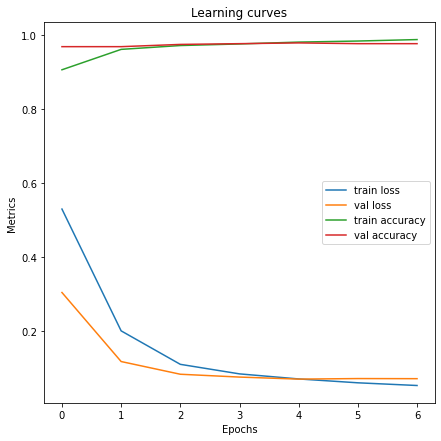

In [30]:
hist2 = model2.fit(MNetV2_features_train, y_train, epochs=50, validation_split=.15, callbacks=callback("MNet")).history
show_result(hist2)

In [31]:
y_pred = model2.predict(MNetV2_features_test)
y_pred[y_pred <= 0.5], y_pred[y_pred > 0.5] = 0, 1
model2 = load_model(data_path + "MNet_model.h5")
print("Accuracy test set:",  accuracy_score(y_test, y_pred))

Accuracy test set: 0.9720873786407767
